In [ ]:
# Tristan Wellman, BCB group, National Phenology Network project
# Purpose: table processing of NPN raster data per feature (e.g. ecoregion) and composite (all features combined)
# Status: working draft, requires additional modification and QA/QC prior to external distribution
# Update date: Nov 29, 2016

# Input specifications (specs in cell below): 
#    (a) set working directory
#    (b) specify local shapfile
#    (c) set NPN data year
#    (d) specify shapefile attribute names for uuid + region name

# operations:
#    (a) reads a raster file from NPN Geoserver and local vector file (shapefile)
#    (b) extracts intersecting raster cells per (shapefile) feature (e.g. watershed, ecoregion)
#    (c) calulates ~20 stat measures for raster cells within in each feature
#    (d) creates a key,value dictionaries of data and statistics results
#    (e) creates a dataframe of ~20 measuers, per feature examined (rows)
#    (f) creates histogram plots per feature (ecoregion)
#    (g) creates a composite dataframe of all features (composite min, max, mean, and stdev)
#    (h) plots histograms of min, max, mean, and median results for all features examined
#    (i) plots composite percentile plots of min, max, mean, and median results (regional result)

In [197]:
# import python modules
import os
import requests
import rasterio.tools.mask
import rasterio
import numpy as np
import random
from pprint import pprint
import pandas
import datetime
import fiona
from osgeo import osr, gdal
from collections import Counter
import matplotlib.pyplot as plt
#from matplotlib.ticker import FuncFormatter
import matplotlib.ticker as mticker
import matplotlib.dates as mdates
from rasterstats import zonal_stats
from timeit import default_timer as timer

# dataframe/output settings
pandas.set_option('display.expand_frame_repr', False)
pandas.set_option('display.max_columns', None)
pandas.set_option('display.max_row', None)
pandas.set_option('display.width',200)
pandas.set_option('precision',2)
np.set_printoptions(precision=1)

tstamp = []
tasklist = []
tasklist.append('time to retrieve + load + process data, perform stats, create dictionaries,' 
                ' create dataframes, and generate multiple plots for all ecoregions')

In [199]:
# Load data, locally for now to match local psql database

# ***************************************
# specifications - temporary for testing
# ***************************************

# feature s.f.r. uuid label attribute  name
uuid = u'URI'

# feature name label attribute  
feat_name = u'FIRST_US_1'

# npn data year
year = 2015      

# ***************************************

# working directory
os.chdir("/Users/twellman/Documents/BCB_data_projects/NPN_BCB/")

# shapefile
shp = 'us_eco_l3_NAD83_Dissolve/us_eco_l3_NAD83_Dissolve.shp'
#with fiona.open(shp, "r") as shapefile:
#    for feature in shapefile:
#        print feature['properties']
        
# raster
raster = ''.join(['https://geoserver.usanpn.org/geoserver/wcs?service=WCS&version=2.0.1&request=GetCoverage&coverageId=',
                  'si-x:average_leaf_prism&time=', str(year), '-01-01&format=geotiff'])
# load raster
print('\nRetrieving raster:')
req = requests.get(raster, verify=False)
with open("NPN.tiff", 'wb') as f:
    f.write(req.content)
f.close()
print('raster loaded')


# open shapefile using fiona module
# used s.f.r. unique identifier and feature name, attribute name specified above  
print('\nRetrieving shapefile:\n')
with fiona.open(shp, "r") as shapefile:
    try:
        uuid_label = [feature['properties'][uuid] for feature in shapefile]
    except Exception, e:
        print('reading shapefile attribute failed, recheck properties')
        print "********** Exception, label error: %s" % str(e)
        pass
    try:
        name_label = [feature['properties'][feat_name] for feature in shapefile]
    except Exception, e:
        print('reading shapefile attribute failed, recheck properties')
        print " ******** Exception, label error: %s" % str(e)
        pass
    try:
        uuid_label = [u.split("/")[-1] for u in uuid_label ]
    except:
        pass
      
    features = [feature["geometry"] for feature in shapefile]
    source_driver = shapefile.driver
    source_crs = shapefile.crs
    source_schema = shapefile.schema
    
    print 'uuid \tfeature name\n' 
    for n,g in zip(uuid_label, name_label):
        print '{}\t{}'.format(n,g)
    
    print('\nshapefile loaded')
    
print('\nfinished read attempts')


Retrieving raster:
raster loaded

Retrieving shapefile:

uuid 	feature name

55c77fbfe4b08400b1fd8302	Coast Range
55c77fbfe4b08400b1fd8304	Columbia Plateau
55c77fbfe4b08400b1fd8306	Blue Mountains
55c77fbfe4b08400b1fd8308	Snake River Plain
55c77fbfe4b08400b1fd830a	Central Basin and Range
55c77fc0e4b08400b1fd830c	Mojave Basin and Range
55c77fc0e4b08400b1fd830e	Northern Rockies
55c77fc0e4b08400b1fd8310	Idaho Batholith
55c77fc0e4b08400b1fd8312	Middle Rockies
55c77fc0e4b08400b1fd8314	Wyoming Basin
55c77fc0e4b08400b1fd8316	Wasatch and Uinta Mountains
55c77fc0e4b08400b1fd8318	Puget Lowland
55c77fc0e4b08400b1fd831a	Colorado Plateaus
55c77fc0e4b08400b1fd831c	Southern Rockies
55c77fc0e4b08400b1fd831e	Arizona/New Mexico Plateau
55c77fc0e4b08400b1fd8320	Arizona/New Mexico Mountains
55c77fc0e4b08400b1fd8322	Chihuahuan Deserts
55c77fc1e4b08400b1fd8324	High Plains
55c77fc1e4b08400b1fd8326	Southwestern Tablelands
55c77fc1e4b08400b1fd8328	Central Great Plains
55c77fc1e4b08400b1fd832a	Flint Hills
55c77

In [200]:
# External comparison: rasterstats is list of dictionaries per feature (e.g. polygon)

#stats_rs = zonal_stats(shp,ras,stats='*')
#print('output variables:\n\n%s\n\nStatistics per shapefile feature:' % (stats_rs[0].keys()))
#stats_rs

In [201]:
# python definitions

# convert julian day to date
def get_date(year, julian):
    return (datetime.datetime(year, 1, 1) + datetime.timedelta(julian - 1)).strftime('%b %d') 

# keys for statistics
keys_dict = ['uuid', 'feature name', 'time [year]','date (earliest)','date (latest)',
        'date (mean)','date (median)','date (mode)','date (p.10th)', 'date (p.20th)',
        'date (p.30th)','date (p.40th)','date (p.50th)','date (p.60th)','date (p.70th)',
        'date (p.80th)','date (p.90th)','unique days [-]','unique days [%]','range days [-]',
        'stdev days [-]','raster cells, all [-]', 'raster cells, mask [-]','raster cells, data [-]']

# statistics dictionary
def create_dict(keys):
    value = [None for f in np.arange(1,len(keys))]
    result = dict(zip(keys, value))
    return result

# calculation attempt
def try_calc(func, failed, handle=lambda e : e, *args, **kwargs):
    try:
        return func(*args, **kwargs)
    except Exception as e:
        return failed 

def histogram_freq(ax,nbin, data, fcolor):
    weights = np.ones_like(data)/float(data.shape[0])
    n, bins, patches = ax.hist(data, nbin, normed=0, linewidth=0.75, facecolor=fcolor, alpha=0.75,weights=weights)
    ax.set_title(title, fontsize=15)
    ax.set_ylabel(ylabeltext, fontsize=12)
    ax.set_xlabel(xlabeltext, fontsize=12)
    ax.tick_params(axis='both', labelsize=12, color='black', labelcolor='black')
    ax.xaxis.set_major_locator(months)
    ax.xaxis.set_major_formatter(monthsFmt)
    ax.grid(True, color='white', linestyle='-', linewidth=0.75)
    ax.set_axis_bgcolor((0.86764706,  0.87941176,  0.89901961))
    formatter = mticker.FuncFormatter(lambda v, pos: str(v * 100.0))
    ax.yaxis.set_major_formatter(formatter)
    ax.set_axisbelow(True)
    cumulative = np.cumsum(n)
    ax_sec = ax.twinx()
    ax_sec.plot(bins[:-1]+0.5*(bins[1]-bins[0]), cumulative, c='yellow', linewidth=2.0)
    ax_sec.set_ylabel('Cumulative frequency [%]',fontsize=12)
    ax_sec.yaxis.set_major_formatter(formatter) 
    legend1 = ax.legend(['bin'], loc="lower center", bbox_to_anchor=(0.88,0.79), shadow=True, frameon=True, 
                fontsize=12, framealpha = 1.0, numpoints = 1)
    legend2 = ax_sec.legend(['cumulative'], loc="lower center", bbox_to_anchor=(0.82,0.60), shadow=True, frameon=True, 
            fontsize=12, framealpha = 1.0, numpoints = 1)
    ax.set_ylim([0.0,0.25])
    ax.set_xlim([1,250])
    ax_sec.set_ylim([0.0,1.05])
    print('Calc check: sum bin (discrete) probability [%]:', np.sum(n)*100.0)
    return


In [202]:
# Example to calculate extended basic stats using numpy, fiona, and rasterio

#loop through polygons (features) as GeoJSON geometries

stat_summary = []
feature_data = {}
with rasterio.open("NPN.tiff") as src:

    out_meta = src.meta.copy() # file metadata
    
    for i,f in enumerate(features):
        # structure dictionary
        results = {}
        results = create_dict(keys_dict)
        results.update({'time [year]': year, 'uuid': uuid_label[i], 'feature name': name_label[i]})
        
        # retrieve raster cell data within vector feature
        try:
            out_image, out_transform =rasterio.mask.mask(src, [f], crop=True, all_touched=False)
        except:
            continue
            
        # reshape / partition data array
        nomask_data = out_image[out_image != out_meta['nodata']]
        data_poly_all = np.reshape(out_image, (np.product(out_image.shape),))
        data_poly_nomask = np.reshape(nomask_data,(np.product(nomask_data.shape),))
        
        feature_data[uuid_label[i]] ={}
        feature_data[uuid_label[i]].update({'time [year]': year, 
                            'feature name': name_label[i],
                            'feature data': data_poly_nomask,
                            'stat_summary_indx':i             
                           })
        
        # perform basic statistics
        if data_poly_nomask.size:
            
            # first,last days
            mind = np.min(data_poly_nomask)
            maxd = np.max(data_poly_nomask)
            
            # most, least frequent days, check redundancy later
            c = Counter(data_poly_nomask)
            val_1, count1 = c.most_common()[0]
            val_2, count2 = c.most_common()[len(c)-1]
            
            # date conversion from year + julian day
            perc = np.percentile(data_poly_nomask,np.arange(10,100,10)).tolist()
            
            pdate = [get_date(results['time [year]'], p)  for p in perc]
            
            mean = np.mean(data_poly_nomask)
            median = np.median(data_poly_nomask)
            
            # statistics per feature
            update_dict = {}
            update_dict = {'date (earliest)' : mind,  
                'date (latest)' : maxd, 
                'date (mean)'   : mean, 
                'date (median)' : median, 
                'date (mode)'   : val_1, 
                'date (p.10th)' : perc[0],
                'date (p.20th)' : perc[1],
                'date (p.30th)' : perc[2],
                'date (p.40th)' : perc[3],
                'date (p.50th)' : perc[4], 
                'date (p.60th)' : perc[5],
                'date (p.70th)' : perc[6],
                'date (p.80th)' : perc[7],
                'date (p.90th)' : perc[8],
                'stdev days [-]'  : np.std(data_poly_nomask),
                'unique days [-]' : len(np.unique(data_poly_nomask)),                     
                'unique days [%]' : len(np.unique(data_poly_nomask))*100.0/len(data_poly_nomask),
                'range days [-]'  : maxd - mind, 
                'stdev days [-]'  : np.std(data_poly_nomask),
                'raster cells, all [-]'  : len(data_poly_all),
                'raster cells, mask [-]' : len(data_poly_all) - len(data_poly_nomask),
                'raster cells, data [-]' : len(data_poly_nomask),
                }
            results.update(update_dict)
   
        else:
            results['count_mask'] = len(data_poly_all)
         
        print 'processing uuid: ' , uuid_label[i]
        stat_summary.append(results)
    
print('\n*** File type (driver): %s ' % source_driver)
print('\n*** CRS coordinate information:\n%s' % source_crs)
print('\n*** Dataset metadata:\n')
pprint(out_meta)
print('\n*** Shapefile schema\n')
pprint(source_schema)
#print('\n*** Summary stats as list of key,value dictionaries\n')
#pprint(stat_summary)


processing uuid:  55c77fbfe4b08400b1fd8302
processing uuid:  55c77fbfe4b08400b1fd8304
processing uuid:  55c77fbfe4b08400b1fd8306
processing uuid:  55c77fbfe4b08400b1fd8308
processing uuid:  55c77fbfe4b08400b1fd830a
processing uuid:  55c77fc0e4b08400b1fd830c
processing uuid:  55c77fc0e4b08400b1fd830e
processing uuid:  55c77fc0e4b08400b1fd8310
processing uuid:  55c77fc0e4b08400b1fd8312
processing uuid:  55c77fc0e4b08400b1fd8314
processing uuid:  55c77fc0e4b08400b1fd8316
processing uuid:  55c77fc0e4b08400b1fd8318
processing uuid:  55c77fc0e4b08400b1fd831a
processing uuid:  55c77fc0e4b08400b1fd831c
processing uuid:  55c77fc0e4b08400b1fd831e
processing uuid:  55c77fc0e4b08400b1fd8320
processing uuid:  55c77fc0e4b08400b1fd8322
processing uuid:  55c77fc1e4b08400b1fd8324
processing uuid:  55c77fc1e4b08400b1fd8326
processing uuid:  55c77fc1e4b08400b1fd8328
processing uuid:  55c77fc1e4b08400b1fd832a
processing uuid:  55c77fc1e4b08400b1fd832c
processing uuid:  55c77fc1e4b08400b1fd832e
processing 

In [218]:
# Currently for NPN, we use key,value dictionary structures. We've begun to explore dataframes as a link 
# to sfr in psql database. To view statistics dictionary, remove comment below on stat_summary. 
# for this example, results shown below are not appended to stats summary.

#stat_summary

In [204]:
# Create Pandas dataframe from key, value dictionary (to match preliminary spatial feature registry work)

print ('\nNPN data statistics per geometric feature (e.g. polygon).'
       '\nDates are shown as julian days from January 1st during %s.\n' % year)

dframe = pandas.DataFrame(columns = keys_dict, index=None)
for i, s in enumerate(stat_summary):
    dframe.loc[i] = pandas.Series(stat_summary[i]) 

for i,j in enumerate(keys_dict):
    try:
        dframe[keys_dict[i]] = dframe[keys_dict[i]].astype(float)
    except:
        continue
dframe.head() 
dframe.round(1)


NPN data statistics per geometric feature (e.g. polygon).
Dates are shown as julian days from January 1st during 2015.



,uuid,feature name,time [year],date (earliest),date (latest),date (mean),date (median),date (mode),date (p.10th),date (p.20th),date (p.30th),date (p.40th),date (p.50th),date (p.60th),date (p.70th),date (p.80th),date (p.90th),unique days [-],unique days [%],range days [-],stdev days [-],"raster cells, all [-]","raster cells, mask [-]","raster cells, data [-]"
0,55c77fbfe4b08400b1fd8302,Coast Range,2015.0,24.0,75.0,33.6,34.0,35.0,26.0,28.0,29.0,31.0,34.0,35.0,37.0,39.0,41.0,35.0,1.0,51.0,6.0,21329.0,17812.0,3517.0
1,55c77fbfe4b08400b1fd8304,Columbia Plateau,2015.0,44.0,103.0,69.0,70.0,70.0,58.0,61.0,66.0,69.0,70.0,71.0,73.0,76.0,80.0,49.0,0.9,59.0,8.1,13770.0,8132.0,5638.0
2,55c77fbfe4b08400b1fd8306,Blue Mountains,2015.0,40.0,149.0,77.2,75.0,72.0,61.0,69.0,71.0,73.0,75.0,77.0,82.0,86.0,94.0,96.0,2.1,109.0,15.2,9039.0,4392.0,4647.0
3,55c77fbfe4b08400b1fd8308,Snake River Plain,2015.0,69.0,119.0,81.4,76.0,72.0,71.0,72.0,73.0,75.0,76.0,81.6,87.0,91.0,97.0,50.0,1.5,50.0,10.8,10368.0,6936.0,3432.0
4,55c77fbfe4b08400b1fd830a,Central Basin and Range,2015.0,29.0,165.0,67.2,72.0,74.0,46.0,56.0,63.0,70.0,72.0,74.0,74.0,76.0,78.0,109.0,0.6,136.0,14.3,31603.0,12973.0,18630.0
5,55c77fc0e4b08400b1fd830c,Mojave Basin and Range,2015.0,21.0,112.0,30.4,30.0,30.0,26.0,26.0,28.0,30.0,30.0,31.0,32.0,33.0,34.0,43.0,0.6,91.0,4.6,12834.0,5506.0,7328.0
6,55c77fc0e4b08400b1fd830e,Northern Rockies,2015.0,55.0,133.0,92.4,89.0,81.0,77.0,81.0,82.0,84.0,89.0,97.0,101.0,104.0,111.0,72.0,1.3,78.0,13.4,10582.0,4889.0,5693.0
7,55c77fc0e4b08400b1fd8310,Idaho Batholith,2015.0,70.0,156.0,108.7,113.0,125.0,80.0,91.0,101.0,105.0,113.0,118.0,120.0,124.0,128.0,76.0,1.9,86.0,18.0,6290.0,2343.0,3947.0
8,55c77fc0e4b08400b1fd8312,Middle Rockies,2015.0,74.0,167.0,112.1,113.0,118.0,83.0,87.0,101.0,106.0,113.0,118.0,122.0,133.0,141.0,93.0,0.9,93.0,21.6,46580.0,35797.0,10783.0
9,55c77fc0e4b08400b1fd8314,Wyoming Basin,2015.0,75.0,141.0,97.5,98.0,85.0,83.0,86.0,89.0,93.0,98.0,100.0,104.0,108.0,114.0,59.0,0.7,66.0,11.8,17812.0,9446.0,8366.0


In [205]:
# sample of data storage structure
# Individual feature data contains uuid, region name, and data, first three feature (ecoregion) shown
feature_data['55c77fc6e4b08400b1fd8388']

{'feature data': masked_array(data = [106 105 105 ..., 78 78 78],
              mask = [False False False ..., False False False],
        fill_value = -9999),
 'feature name': u'Western Allegheny Plateau',
 'stat_summary_indx': 67,
 'time [year]': 2015}

In [206]:
# added index locator pointing to stats_summary to allow direct query 
# both uuid and feature name are stored in feature data and stat summary
stat_summary[feature_data['55c77fc6e4b08400b1fd8388']['stat_summary_indx']]

{'date (earliest)': 78,
 'date (latest)': 106,
 'date (mean)': 92.375279528359428,
 'date (median)': 94.0,
 'date (mode)': 98,
 'date (p.10th)': 84.0,
 'date (p.20th)': 84.0,
 'date (p.30th)': 86.0,
 'date (p.40th)': 90.0,
 'date (p.50th)': 94.0,
 'date (p.60th)': 97.0,
 'date (p.70th)': 98.0,
 'date (p.80th)': 98.0,
 'date (p.90th)': 100.0,
 'feature name': u'Western Allegheny Plateau',
 'range days [-]': 28,
 'raster cells, all [-]': 14040,
 'raster cells, data [-]': 4919,
 'raster cells, mask [-]': 9121,
 'stdev days [-]': 6.9478824501348715,
 'time [year]': 2015,
 'unique days [%]': 0.5895507216914007,
 'unique days [-]': 29,
 'uuid': u'55c77fc6e4b08400b1fd8388'}

In [207]:
# Create julian-day/days composite summaries for all features (selected, or in shapefile (file))

print ('\nNPN composite data statistics for all geometric features.'
       '\nPredicted julian days are during %s.\n' % year)

# disregard table column attributes less relevant for composite analyses 
s_indx = 3

analyses = ['composite mean', 'composite min', 'composite max', 'composite std']
dframe_composite = pandas.DataFrame(columns = keys_dict[s_indx:], index=analyses)

summary_dict = {}
summary_dict.update(
               {'composite mean': [try_calc(lambda : np.mean(dframe[k]),None) for k in keys_dict[s_indx:]],
                'composite min' : [try_calc(lambda : np.min(dframe[k]),None) for k in keys_dict[s_indx:]],
                'composite max' : [try_calc(lambda : np.max(dframe[k]),None) for k in keys_dict[s_indx:]],
                'composite std' : [try_calc(lambda : np.std(dframe[k]),None) for k in keys_dict[s_indx:]]
               }
              )

for i, s in enumerate(analyses):
    result_dict = dict(zip(keys_dict[s_indx:], summary_dict[s]))
    dframe_composite.loc[analyses[i]] = pandas.Series(result_dict)

for i,j in enumerate(keys_dict[s_indx:]):
    try:
        dframe_composite[j] = dframe_composite[j].astype(float)
    except:
        continue
           
dframe_composite.head()
dframe_composite.round(1)


NPN composite data statistics for all geometric features.
Predicted julian days are during 2015.



,date (earliest),date (latest),date (mean),date (median),date (mode),date (p.10th),date (p.20th),date (p.30th),date (p.40th),date (p.50th),date (p.60th),date (p.70th),date (p.80th),date (p.90th),unique days [-],unique days [%],range days [-],stdev days [-],"raster cells, all [-]","raster cells, mask [-]","raster cells, data [-]"
composite mean,55.1,101.9,73.1,72.9,71.0,62.5,65.5,67.8,70.0,72.9,75.4,77.7,80.5,84.2,37.5,1.0,46.8,8.6,18036.1,12492.6,5543.5
composite min,6.0,13.0,8.4,9.0,9.0,7.0,7.0,7.0,7.0,9.0,9.0,9.0,10.0,10.0,6.0,0.2,7.0,1.2,2002.0,1109.0,821.0
composite max,115.0,173.0,120.2,123.0,125.0,117.0,117.0,118.0,119.0,123.0,123.0,124.0,139.0,153.0,112.0,5.1,148.0,35.4,86632.0,68368.0,23766.0
composite std,29.7,36.3,29.3,29.6,30.7,29.7,29.7,29.5,29.5,29.6,29.8,29.8,30.6,32.1,28.7,1.0,35.5,6.9,15689.5,12637.5,4516.2


In [208]:
# Create date formatted /days composite summaries for all features (selected, or in shapefile (file))

print ('\nNPN composite data statistics for all geometric features.'
       '\nPredicted dates are during %s.\n' % year)

dframe_comp_date = dframe_composite[:-1].copy(deep=True)

for k in keys_dict[3:-7]:
    dframe_comp_date[k] = [ (datetime.datetime(year, 1, 1) + 
               datetime.timedelta(julian - 1)).strftime('%b %d') for i, julian in enumerate(dframe_comp_date[k])]

dframe_comp_date.head()
dframe_comp_date.round(1)


NPN composite data statistics for all geometric features.
Predicted dates are during 2015.



,date (earliest),date (latest),date (mean),date (median),date (mode),date (p.10th),date (p.20th),date (p.30th),date (p.40th),date (p.50th),date (p.60th),date (p.70th),date (p.80th),date (p.90th),unique days [-],unique days [%],range days [-],stdev days [-],"raster cells, all [-]","raster cells, mask [-]","raster cells, data [-]"
composite mean,Feb 24,Apr 11,Mar 14,Mar 13,Mar 12,Mar 03,Mar 06,Mar 08,Mar 11,Mar 13,Mar 16,Mar 18,Mar 21,Mar 25,37.5,1.0,46.8,8.6,18036.1,12492.6,5543.5
composite min,Jan 06,Jan 13,Jan 08,Jan 09,Jan 09,Jan 07,Jan 07,Jan 07,Jan 07,Jan 09,Jan 09,Jan 09,Jan 10,Jan 10,6.0,0.2,7.0,1.2,2002.0,1109.0,821.0
composite max,Apr 25,Jun 22,Apr 30,May 03,May 05,Apr 27,Apr 27,Apr 28,Apr 29,May 03,May 03,May 04,May 19,Jun 02,112.0,5.1,148.0,35.4,86632.0,68368.0,23766.0



Histograms for specific geometries (ecoregions).
Subplots show distributions of predicted leaf dates
for specifed regions during 2015.

('Calc check: sum bin (discrete) probability [%]:', 99.999999999999972)
('Calc check: sum bin (discrete) probability [%]:', 99.999999999999517)
('Calc check: sum bin (discrete) probability [%]:', 100.00000000000033)
('Calc check: sum bin (discrete) probability [%]:', 100.00000000000051)


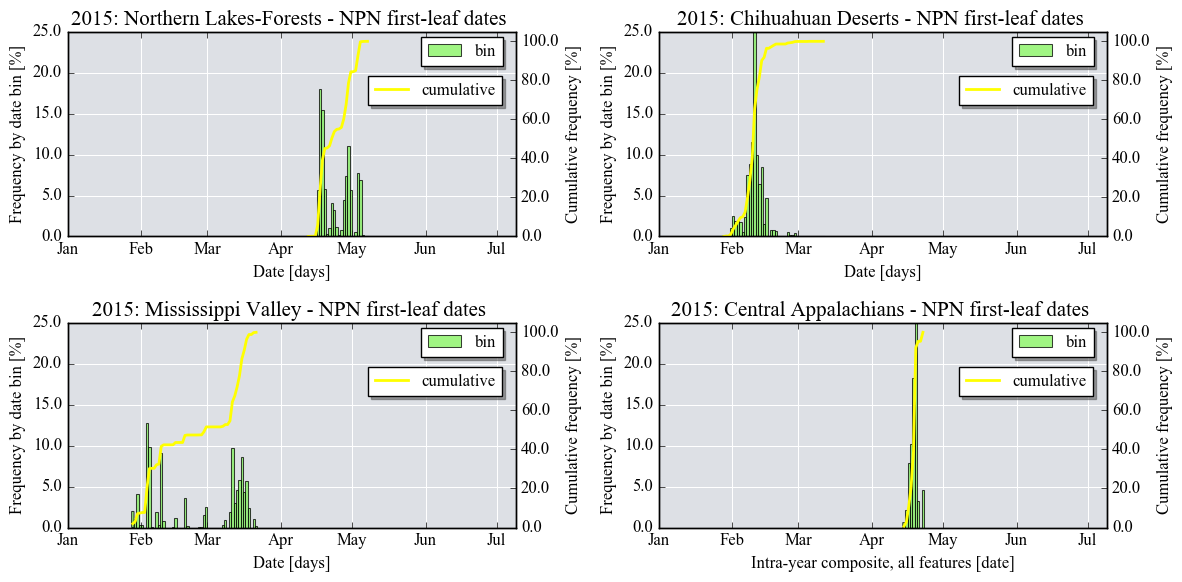

In [224]:
print ('\nHistograms for specific geometries (ecoregions).'
       '\nSubplots show distributions of predicted leaf dates\n'
       'for specifed regions during %s.\n' % year)

# create subplots
plt.rcParams.update({'font.family': "Times New Roman",'font.size': 12})
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 6), sharex=False)
months = mdates.MonthLocator()
monthsFmt = mdates.DateFormatter("%b")

# plot feature results

binsize = 1.0 # days
fc = (0.5, .95, 0.35)

# plt 1: histogram feature (Northern Lakes and Forests)
data_src = feature_data['55c77fc4e4b08400b1fd835c']['feature data'] 
data_src2 = data_src[~data_src.mask]
xlabeltext = 'Date [days]'
ylabeltext = 'Frequency by date bin [%]'
title = '%d: %s ' % (year, 'Northern Lakes-Forests - NPN first-leaf dates')
span = data_src.max() - data_src.min()
bins = np.maximum(int(span/binsize),1)
histogram_freq(ax1, bins, data_src2,fc)

# plt 2: histogram feature ('Chihuahuan Deserts')
data_src = feature_data['55c77fc0e4b08400b1fd8322']['feature data']
xlabeltext = 'Date [days]'
ylabeltext = 'Frequency by date bin [%]'
title = '%d: %s ' % (year, 'Chihuahuan Deserts - NPN first-leaf dates')
span = data_src.max() - data_src.min()
bins = np.maximum(int(span/binsize),1)
histogram_freq(ax2, bins, data_src,fc)

# plt 3: histogram feature (Mississippi Valley Loess Plains)
data_src = feature_data['55c77fc6e4b08400b1fd8390']['feature data']
xlabeltext = 'Date [days]'
ylabeltext = 'Frequency by date bin [%]'
title = '%d: %s ' % (year, 'Mississippi Valley - NPN first-leaf dates')
span = data_src.max() - data_src.min()
bins = np.maximum(int(span/binsize),1)
histogram_freq(ax3, bins, data_src,fc)

# plt 4:  histogram feature (North Central Appalachians)
data_src = feature_data['55c77fc6e4b08400b1fd8376']['feature data']
xlabeltext = 'Intra-year composite, all features [date]'
ylabeltext = 'Frequency by date bin [%]'
title = '%d: %s ' % (year, 'Central Appalachians - NPN first-leaf dates')
span = data_src.max() - data_src.min()
bins = np.maximum(int(span/binsize),1)
histogram_freq(ax4, bins, data_src,fc)

# enable input in future
ax1.set_xlim([1,190])
ax2.set_xlim([1,190])
ax3.set_xlim([1,190])
ax4.set_xlim([1,190])

plt.tight_layout()
plt.show()



Composite histogram of results for all features (e.g. ecoregions).
Subplots display distributions of earliest, latest, average and median
predicted leaf dates per feature during 2015.

('Calc check: sum bin (discrete) probability [%]:', 99.999999999999986)
('Calc check: sum bin (discrete) probability [%]:', 100.0)
('Calc check: sum bin (discrete) probability [%]:', 100.0)
('Calc check: sum bin (discrete) probability [%]:', 100.0)


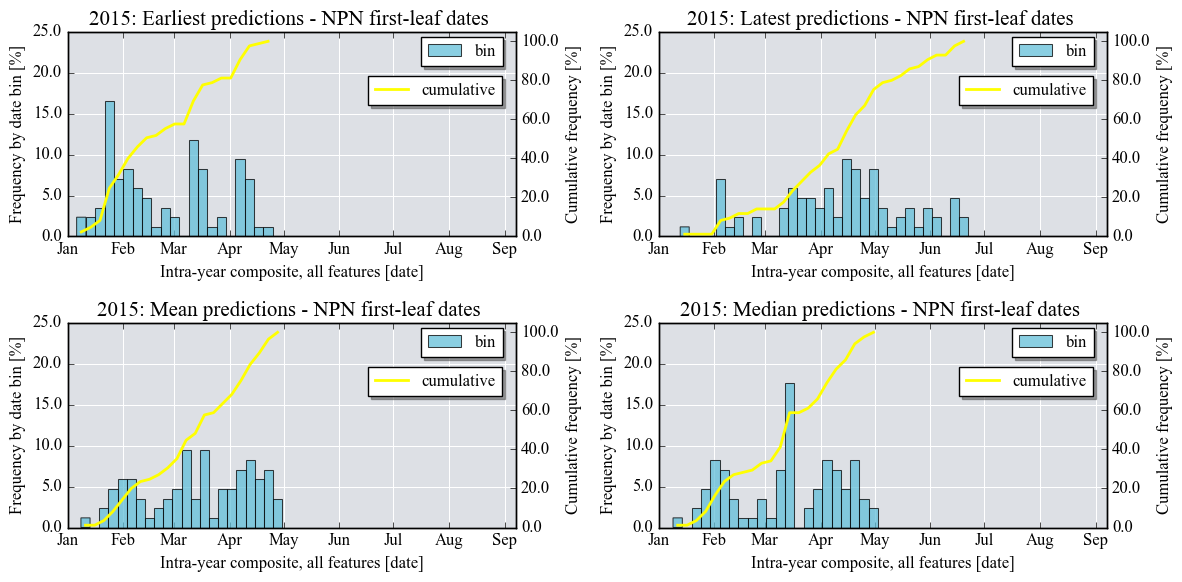

In [222]:
print ('\nComposite histogram of results for all features (e.g. ecoregions).'
       '\nSubplots display distributions of earliest, latest, average and median\n'
       'predicted leaf dates per feature during %s.\n' % year)

# create subplots
plt.rcParams.update({'font.family': "Times New Roman",'font.size': 12})
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 6), sharex=False)
months = mdates.MonthLocator()
monthsFmt = mdates.DateFormatter("%b")

# plot summary results

binsize = 5.0 # days
fc = (0.39, .75, 0.85)

# plt 1: histogram  - frequency -  earliest
data_src = dframe['date (earliest)']
xlabeltext = 'Intra-year composite, all features [date]'
ylabeltext = 'Frequency by date bin [%]'
title = '%d: %s ' % (year, 'Earliest predictions - NPN first-leaf dates')
span = data_src.max() - data_src.min()
bins = np.maximum(int(span/binsize),1)
histogram_freq(ax1, bins, data_src,fc)

# plt 2: histogram  - frequency -  latest
data_src = dframe['date (latest)']
xlabeltext = 'Intra-year composite, all features [date]'
ylabeltext = 'Frequency by date bin [%]'
title = '%d: %s ' % (year, 'Latest predictions - NPN first-leaf dates')
span = data_src.max() - data_src.min()
bins = np.maximum(int(span/binsize),1)
histogram_freq(ax2, bins, data_src,fc)

# plt 3: histogram  - frequency -  mean
data_src = dframe['date (mean)']
xlabeltext = 'Intra-year composite, all features [date]'
ylabeltext = 'Frequency by date bin [%]'
title = '%d: %s ' % (year, 'Mean predictions - NPN first-leaf dates')
span = data_src.max() - data_src.min()
bins = np.maximum(int(span/binsize),1)
histogram_freq(ax3, bins, data_src,fc)

# plt 4: histogram  - frequency -  mean
data_src = dframe['date (median)']
xlabeltext = 'Intra-year composite, all features [date]'
ylabeltext = 'Frequency by date bin [%]'
title = '%d: %s ' % (year, 'Median predictions - NPN first-leaf dates')
span = data_src.max() - data_src.min()
bins = np.maximum(int(span/binsize),1)
histogram_freq(ax4, bins, data_src,fc)


plt.tight_layout()
plt.show()



Percentile composite histogram plots of all features (e.g. ecoregions).
Subplots display distributions of 10th, 30th, 60th, and 90th percentiles
of predicted leaf dates per feature during 2015.

('Calc check: sum bin (discrete) probability [%]:', 100.0)
('Calc check: sum bin (discrete) probability [%]:', 99.999999999999986)
('Calc check: sum bin (discrete) probability [%]:', 100.0)
('Calc check: sum bin (discrete) probability [%]:', 99.999999999999986)


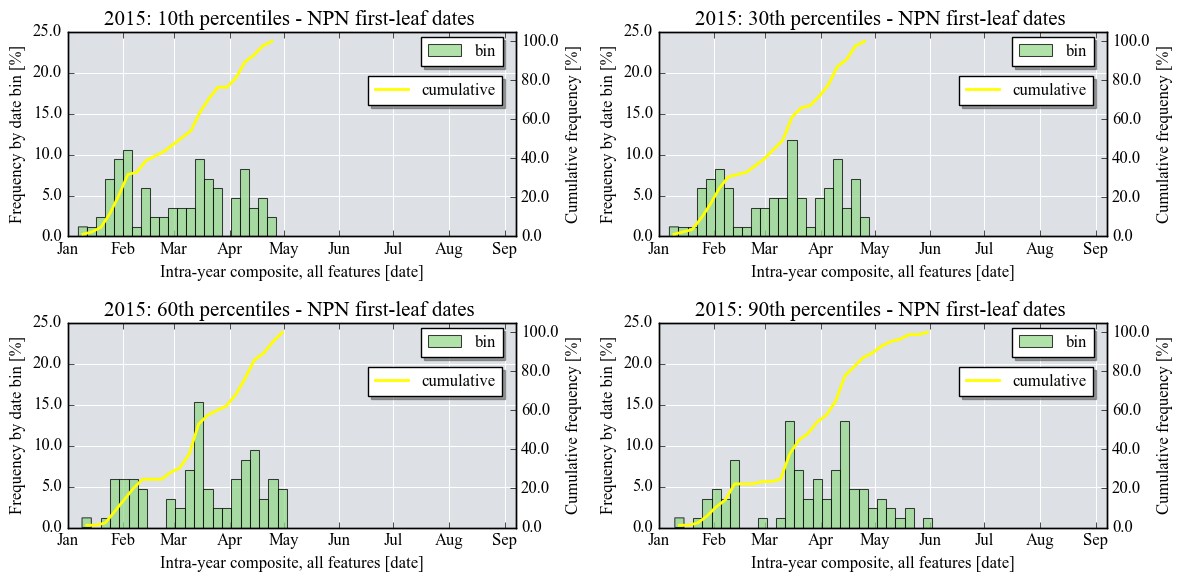

In [220]:
print ('\nPercentile composite histogram plots of all features (e.g. ecoregions).'
       '\nSubplots display distributions of 10th, 30th, 60th, and 90th percentiles\n'
       'of predicted leaf dates per feature during %s.\n' % year)


# create subplots
plt.rcParams.update({'font.family': "Times New Roman",'font.size': 12})
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 6), sharex=False)
months = mdates.MonthLocator()
monthsFmt = mdates.DateFormatter("%b")

# plot summary results

binsize = 5 # days
fc = (0.59, .85, 0.55)

# plt 1: histogram  - frequency -  10th percentile
data_src = dframe['date (p.10th)']
xlabeltext = 'Intra-year composite, all features [date]'
ylabeltext = 'Frequency by date bin [%]'
title = '%d: %s ' % (year, '10th percentiles - NPN first-leaf dates')
span = data_src.max() - data_src.min()
bins = np.maximum(int(span/binsize),1)
histogram_freq(ax1, bins, data_src,fc)

# plt 2: histogram  - frequency -  30th percentile
data_src = dframe['date (p.30th)']
xlabeltext = 'Intra-year composite, all features [date]'
ylabeltext = 'Frequency by date bin [%]'
title = '%d: %s ' % (year, '30th percentiles - NPN first-leaf dates')
span = data_src.max() - data_src.min()
bins = np.maximum(int(span/binsize),1)
histogram_freq(ax2, bins, data_src,fc)

# plt 3: histogram  - frequency -  60th percentile
data_src = dframe['date (p.60th)']
xlabeltext = 'Intra-year composite, all features [date]'
ylabeltext = 'Frequency by date bin [%]'
title = '%d: %s ' % (year, '60th percentiles - NPN first-leaf dates')
span = data_src.max() - data_src.min()
bins = np.maximum(int(span/binsize),1)
histogram_freq(ax3, bins, data_src,fc)

# plt 4: histogram  - frequency -  90th percentile
data_src = dframe['date (p.90th)']
xlabeltext = 'Intra-year composite, all features [date]'
ylabeltext = 'Frequency by date bin [%]'
title = '%d: %s ' % (year, '90th percentiles - NPN first-leaf dates')
span = data_src.max() - data_src.min()
bins = np.maximum(int(span/binsize),1)
histogram_freq(ax4, bins, data_src,fc)


plt.tight_layout()
plt.show()



In [214]:
tstamp.append(timer())
for i in range(len(tstamp)-1):
    print('Task '+ str(i+1) + ': ' + tasklist[i] + ' | Runtime [secs]: '+ str(round(tstamp[i+1]-tstamp[i],3)))

Task 1: time to retrieve + load + process data, perform stats, create dictionaries, create dataframes, and generate multiple plots for all ecoregions | Runtime [secs]: 25.076


In [213]:
# Set up to main arg call when complete

# set up main call
# if __name__ == "__main__":
# keys for statistics